In [235]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

import pandas as pd  
import warnings  
warnings.filterwarnings("ignore")

In [129]:
df3 = pd.read_excel('data/4sheet/3.xlsx', engine='openpyxl')
df4 = pd.read_excel('data/4sheet/4.xlsx', engine='openpyxl')
df4.columns = df3.columns  
data = pd.concat([df3, df4], axis=0)

KeyboardInterrupt: 

In [ ]:
start_date = '2024-03-01'  
end_date = '2024-03-07'  
filtered_df = data[(data['下单时间'] >= start_date) & (data['下单时间'] <= end_date)]    

print('删除前数据条数', filtered_df.shape[0])

time_cols = [col for col in filtered_df.columns if '时间' in col]
for col in time_cols:
    filtered_df[col] = pd.to_datetime(filtered_df[col], errors='coerce')    
    filtered_df = filtered_df.dropna(subset=[col])  
filtered_df['下单时间'] = filtered_df['下单时间'].astype(str)
# 定义正则表达式模式，匹配并提取A和B
pattern = r'(\w+):(\w+)'
filtered_df[['小时', '分钟']] = filtered_df['下单时间'].str.extract(pattern)
filtered_df['小时'] = pd.to_numeric(filtered_df['小时'], errors='coerce')
filtered_df['分钟'] = pd.to_numeric(filtered_df['分钟'], errors='coerce')
filtered_df['分钟桶'] = filtered_df['小时'] * 60 + filtered_df['分钟']
filtered_df['日期'] = filtered_df['下单时间'].astype(str)
filtered_df['日期'] = filtered_df['日期'].apply(lambda x : x.split(" ")[0])

print('删除后数据条数', filtered_df.shape[0])

## 按城市保存数据

In [130]:
for city_id in set(filtered_df['城市']):
    data_clean_city = filtered_df[filtered_df['城市'] == city_id]
    data_clean_city.to_csv(f"./data/citylog/{city_id}_log.csv", index = False)

## 分桶保留最后一次派单时间的数据

In [175]:
df = filtered_df[['订单编号', '派单时间', '分配类型']] 
# 假设df是您的DataFrame
# 对数据按订单编号和派单类型分组，计算每个分组的最大最小时间以及计数
grouped = df.groupby(['订单编号', '分配类型']).agg(
    最大派单时间=('派单时间', 'max'),
    最小派单时间=('派单时间', 'min'),
    派单数量=('派单时间', 'count')
).reset_index()

# 对分组结果进行透视，以便将人工和机器派单分开到不同的列
pivot_df = grouped.pivot_table(index='订单编号', 
                               columns='分配类型', 
                               values=['最大派单时间', '最小派单时间', '派单数量'],
                               aggfunc='first').fillna(0)

pivot_df.columns = ['_'.join(col) for col in pivot_df.columns]
pivot_df.rename(columns={'最大派单时间_人工派单': '人工派单最大时间',
                         '最大派单时间_机器派单': '机器派单最大时间',
                         '最小派单时间_人工派单': '人工派单最小时间',
                         '最小派单时间_机器派单': '机器派单最小时间',
                         '派单数量_人工派单': '人工派单次数',
                         '派单数量_机器派单': '机器派单次数'}, inplace=True)
pivot_df.reset_index(inplace=True)

# # 计算每个订单的最大和最小派单时间（不区分人工或机器）
order_times = df.groupby('订单编号')['派单时间'].agg(最大派单时间='max', 最小派单时间='min').reset_index()

# # 合并订单的最大最小时间与派单类型的统计信息
final_df = pd.merge(order_times, pivot_df, on='订单编号', how='left')
final_df['最终类型'] = final_df.apply(lambda row: '人工' if row['最大派单时间_人工分配'] == row['最大派单时间'] else '机器', axis=1)

In [176]:
cols = ['订单编号','下单时间','开始调度时间', '骑手接单时间','骑手到店时间','骑手取餐时间','骑手到达时间','导航距离','小时','分钟','分钟桶']
filtered_df_unique= filtered_df[cols].drop_duplicates(subset=cols)

In [177]:
time_df = filtered_df_unique.merge(final_df)

In [178]:
# 定义一个函数来移除列名中的特定字符串
def rename_columns(columns, ignore_strings):
    return [col.replace(s, '').strip() for s in ignore_strings for col in columns]

# 要忽略的字符串列表
ignore_strings = ["时间"]

# 重新命名列名
new_column_names = rename_columns(time_df.columns.tolist(), ignore_strings)
# 应用新的列名
time_df.columns = new_column_names

ignore_strings = ["骑手"]
new_column_names = rename_columns(time_df.columns.tolist(), ignore_strings)
# 应用新的列名
time_df.columns = new_column_names

In [179]:
time_df['派单-接单'] = (time_df['接单'] - time_df['最大派单']).dt.seconds
time_df['接单-到店'] = (time_df['到店'] - time_df['接单']).dt.seconds
time_df['到店-取餐'] = (time_df['取餐'] - time_df['到店']).dt.seconds
time_df['取餐-到达'] = (time_df['到达'] - time_df['取餐']).dt.seconds
time_df['派单时长'] = (time_df['最大派单'] - time_df['最小派单']).dt.seconds

In [239]:
time_df.columns

Index(['订单编号', '下单', '开始调度', '接单', '到店', '取餐', '到达', '导航距离', '小时', '分钟', '分钟桶',
       '最大派单', '最小派单', '最大派单_人工分配', '最大派单_自动分配', '最小派单_人工分配', '最小派单_自动分配',
       '派单数量_人工分配', '派单数量_自动分配', '最终类型', '派单-接单', '接单-到店', '到店-取餐', '取餐-到达',
       '派单时长'],
      dtype='object')

In [180]:
cols = ['派单-接单', '接单-到店', '到店-取餐', '取餐-到达', '派单时长']

quantiles = np.array([i * 10 for i in range(1, 11)])
quantile_df = time_df[cols].quantile(quantiles/100, axis=0)
quantile_df = quantile_df.T
quantile_df.head()

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
派单-接单,4.0,5.0,7.0,8.0,9.0,11.0,13.0,17.0,28.0,1508.0
接单-到店,57.0,92.0,122.0,154.0,190.0,234.0,293.0,383.0,546.0,82456.0
到店-取餐,27.0,47.0,79.0,131.0,198.0,283.0,391.0,540.0,795.0,72883.0
取餐-到达,180.0,260.0,331.0,400.0,472.0,552.0,649.0,781.0,1022.0,72945.0
派单时长,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63434.0


In [181]:
# 将numpy数组转换为字符串数组
quantiles = quantiles.astype(str)
quantile_df = round(quantile_df/60,2)

In [182]:
#quantile_df.head()
sums = quantile_df.sum()
new_row = pd.DataFrame([sums])
quantile_df = quantile_df.append(new_row)
quantile_df.index = quantile_df.index.tolist()[:-1] + ['中位数过程求和']  # 替换最后一行的索引
quantile_df.head(20)

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
派单-接单,0.07,0.08,0.12,0.13,0.15,0.18,0.22,0.28,0.47,25.13
接单-到店,0.95,1.53,2.03,2.57,3.17,3.90,4.88,6.38,9.10,1374.27
到店-取餐,0.45,0.78,1.32,2.18,3.30,4.72,6.52,9.00,13.25,1214.72
取餐-到达,3.00,4.33,5.52,6.67,7.87,9.20,10.82,13.02,17.03,1215.75
派单时长,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1057.23
中位数过程求和,4.47,6.72,8.99,11.55,14.49,18.00,22.44,28.68,39.85,4887.10


In [197]:
# 定义分位点列表
quantiles = np.arange(0.1, 1.01, 0.1)

# 函数来计算每列的分位数并构造新DataFrame
def compute_quantiles(df, columns):
    quantile_df = pd.DataFrame()
    for col in columns:
        # 计算每个班级每列的指定分位数
        quant_col = df.groupby('小时')[col].quantile(quantiles).unstack().reset_index()
        quant_col.columns = ['小时'] + [f"{col}_{int(q*100)}%" for q in quantiles]
        quantile_df = pd.concat((quantile_df, quant_col), axis=1)
    return quantile_df
# 调用函数，传入需要计算分位数的列名列表
final_result = compute_quantiles(time_df, cols)

In [204]:
final_result.shape
final_result.to_csv('r_0502.csv',  encoding='utf-8')

In [236]:
time_columns = [col for col in final_result.columns if '派单-接单' in col]
r = final_result[time_columns]
r.head(24)

time_columns = [col for col in final_result.columns if '接单-到店' in col]
r = final_result[time_columns]
r.head(24)

,派单-接单_10%,派单-接单_20%,派单-接单_30%,派单-接单_40%,派单-接单_50%,派单-接单_60%,派单-接单_70%,派单-接单_80%,派单-接单_90%,派单-接单_100%
0,4.0,5.0,7.0,8.0,10.0,12.0,14.0,19.0,32.7,221.0
1,4.0,6.0,7.0,8.0,10.0,12.0,15.0,20.0,31.0,175.0
2,4.0,5.0,6.0,8.0,10.0,13.0,17.0,23.8,40.0,176.0
3,4.0,5.0,7.0,8.0,10.0,13.0,17.0,21.0,37.0,172.0
4,4.0,6.0,7.0,9.0,12.0,15.0,20.0,26.0,37.0,137.0
5,5.0,7.0,9.0,10.0,12.0,16.0,20.0,26.0,50.0,153.0
6,5.0,6.0,7.0,9.0,10.0,13.0,19.5,30.0,53.0,175.0
7,4.0,5.0,6.0,8.0,9.0,11.0,13.0,17.0,28.0,313.0
8,4.0,5.0,6.0,7.0,9.0,10.0,12.0,16.0,25.0,223.0
9,4.0,5.0,6.0,7.0,9.0,10.0,12.0,16.0,24.0,379.0


,接单-到店_10%,接单-到店_20%,接单-到店_30%,接单-到店_40%,接单-到店_50%,接单-到店_60%,接单-到店_70%,接单-到店_80%,接单-到店_90%,接单-到店_100%
0,26.0,74.0,106.0,141.0,180.0,225.8,299.0,403.0,575.0,2401.0
1,20.0,73.0,113.0,145.0,185.0,237.0,316.0,435.0,632.0,2606.0
2,73.0,114.2,151.8,191.0,235.0,293.6,368.2,489.6,663.6,1748.0
3,55.0,117.0,157.0,202.0,247.0,289.0,406.0,531.0,741.0,14647.0
4,55.0,106.0,172.0,226.0,277.0,364.0,445.0,555.0,740.0,82456.0
5,28.0,103.0,176.0,232.0,294.0,395.0,477.0,618.0,918.0,75704.0
6,81.0,130.0,193.0,242.0,301.5,359.0,439.5,531.0,725.5,2542.0
7,50.0,88.0,124.0,161.0,201.0,250.0,313.0,416.0,574.0,2529.0
8,37.0,72.0,98.0,127.0,159.0,201.0,247.2,321.0,464.4,2680.0
9,33.0,68.0,93.0,118.0,146.0,181.0,227.0,300.0,445.5,2596.0


<Axes: xlabel='取餐-到达', ylabel='导航距离'>

Text(0.5, 1.0, 'Scatter Plot Example')

Text(0.5, 0, 'X Variable')

Text(0, 0.5, 'Y Variable')

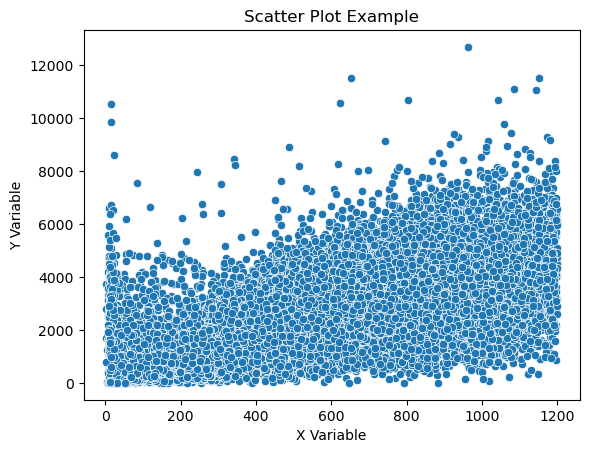

0.705


In [281]:
# s = filtered_df[(filtered_df['城市'] == 'PNH') & (filtered_df['站点'] == 10033)]
# wb_set = set(s['订单编号'])
# r = time_df[(time_df['订单编号'].isin(wb_set)) & (time_df['取餐-到达'] < 1200)]
# correlation = round(r['取餐-到达'].corr(r['导航距离']), 3)


# sns.scatterplot(x='取餐-到达', y='导航距离', data=r)
# # 添加标题和坐标轴标签
# plt.title('Scatter Plot Example')
# plt.xlabel('X Variable')
# plt.ylabel('Y Variable')

# # 显示图表
# plt.show()

# print(correlation)

In [295]:
s = filtered_df[(filtered_df['城市'] == 'PNH') & (filtered_df['站点'] == 10034)]
wb_set = set(s['订单编号'])
r = time_df[(time_df['订单编号'].isin(wb_set)) & (time_df['取餐-到达']< 6000)]

correlation = round(r['取餐-到达'].corr(r['导航距离']), 3)
print(correlation)

0.627


In [274]:
quantiles = np.array([i * 0.05 for i in range(1, 21)])
r['取餐-到达'].describe(quantiles) 
r = r[r['取餐-到达'] < 1200]
r = time_df[time_df['订单编号'].isin(wb_set)]
correlation = round(r['取餐-到达'].corr(r['导航距离']), 3)

count    55846.000000
mean       550.329513
std        366.955764
min          1.000000
5%         134.000000
10%        187.000000
15%        227.000000
20%        267.000000
25%        303.000000
30%        339.000000
35%        374.000000
40%        408.000000
45%        444.000000
50%        480.000000
55%        517.000000
60%        557.000000
65%        600.000000
70%        649.000000
75%        705.000000
80%        772.000000
85%        858.000000
90%        983.500000
95%       1211.000000
100%     10095.000000
max      10095.000000
Name: 取餐-到达, dtype: float64

In [269]:
s = filtered_df[(filtered_df['城市'] == 'PNH') & (filtered_df['站点'] == 10033)]
wb_set = set(s['订单编号'])
r = time_df[time_df['订单编号'].isin(wb_set)]
correlation = round(r['取餐-到达'].corr(r['导航距离']), 3)
print(correlation)

0.517


In [270]:
s = filtered_df[(filtered_df['城市'] == 'PNH') & (filtered_df['站点'] == 10034)]
wb_set = set(s['订单编号'])
r = time_df[time_df['订单编号'].isin(wb_set)]
correlation = round(r['取餐-到达'].corr(r['导航距离']), 3)
print(correlation)

0.624


In [304]:
filtered_df.columns

Index(['城市', '站点', '订单编号', '派单轮次', '分配骑手', '分配类型', '下单时间', '开始调度时间', '派单时间',
       '骑手接单时间', '骑手到店时间', '骑手取餐时间', '骑手到达时间', '导航距离', '配送状态', '分配时骑手经度',
       '分配时骑手纬度', '分配距离_直线', '准确', '小时', '分钟', '分钟桶', '日期'],
      dtype='object')

In [309]:
filtered_df['分配标记'] = np.where(filtered_df['分配类型'] == '人工分配', '2', '1')
# 按照学生ID和时间排序
sorted_df = filtered_df.sort_values(by=['订单编号', '派单时间'])

# 分组并拼接行为和时间
# 使用groupby后，apply函数可以对每个组应用自定义函数
# 在这里，我们将行为和时间用' - '连接，并且在每个学生的行为序列前加上学生ID
def concatenate_behaviors(group):
    # 将行为和时间拼接，并在前面加上学生ID
    behaviors_time = group.apply(lambda row: f"{row['分配标记']}", axis=1)
    # 返回拼接后的字符串，用'; '分隔
    return ''.join(behaviors_time)

result = sorted_df.groupby('订单编号').apply(concatenate_behaviors).reset_index()
result.columns = ['订单编号', '分配标记']

result.head()

,订单编号,分配标记
0,1763247956585115648,2
1,1763247981091889152,1
2,1763248058112438272,2
3,1763248162121912320,1
4,1763248178274508800,2


In [314]:
r = result['分配标记'].value_counts().reset_index()
r.columns = ['分类类别', '数量']
r.head()

,分类类别,数量
0,1,101522
1,2,37514
2,12,2013
3,22,1962
4,222,312


In [323]:
r['占比'] = round(r['数量'] / r['数量'].sum(), 4) * 100

In [329]:
top_4 = r.head(4)
remaining_sum = r['占比'][4:].sum()
new_df = pd.concat([top_4, pd.DataFrame({'考试分数': [remaining_sum]})], ignore_index=True)
new_df.head()

,分类类别,数量,占比
0,1,101522,70.56
1,2,37514,26.07
2,12,2013,1.40
3,22,1962,1.36
4,222,312,0.22
5,122,309,0.21
6,1222,80,0.06
7,2222,67,0.05
8,22222,22,0.02
9,12222,18,0.01


<Axes: xlabel='分类类别', ylabel='占比'>

Text(0.5, 1.0, 'Mean Value per Category')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]),
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '12'),
  Text(3, 0, '22'),
  Text(4, 0, '222'),
  Text(5, 0, '122'),
  Text(6, 0, '1222'),
  Text(7, 0, '2222'),
  Text(8, 0, '22222'),
  Text(9, 0, '12222'),
  Text(10, 0, '11'),
  Text(11, 0, '222222'),
  Text(12, 0, '21'),
  Text(13, 0, '122222'),
  Text(14, 0, '22222222'),
  Text(15, 0, '212'),
  Text(16, 0, '2222222'),
  Text(17, 0, '12222222222'),
  Text(18, 0, '1222222'),
  Text(19, 0, '222222222222222'),
  Text(20, 0, '12222222'),
  Text(21, 0, '122222222')])

Text(0.5, 0, 'Categories')

Text(0, 0.5, 'Mean Value')

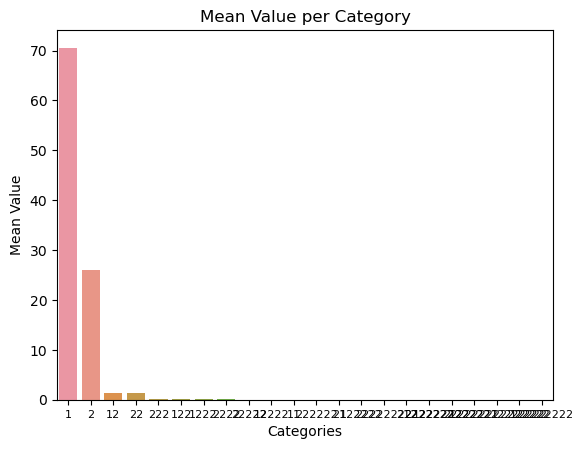

In [328]:
# 绘制柱状图
sns.barplot(x="分类类别", y="占比", data=r)

# 添加标题和标签
plt.title('Mean Value per Category')
plt.xticks(fontsize=3)
plt.xlabel('Categories')
plt.ylabel('Mean Value')

# 显示图表
plt.show()

,分类类别,数量,占比
0,1,101522,70.56
1,2,37514,26.07
2,12,2013,1.40
3,22,1962,1.36
4,other,861,0.60


<Axes: xlabel='分类类别', ylabel='占比'>

Text(0.5, 1.0, 'Mean Value per Category')

Text(0.5, 0, 'Categories')

Text(0, 0.5, 'Mean Value')

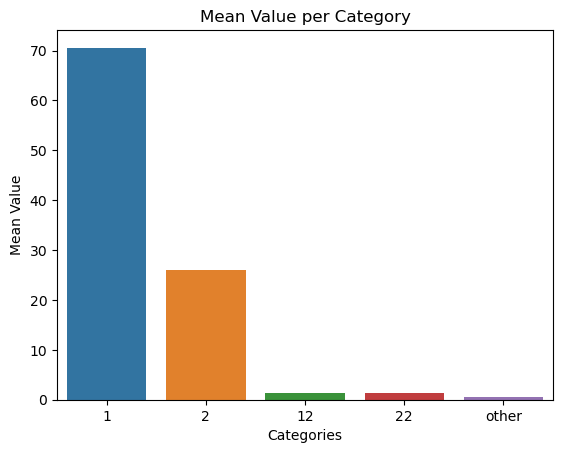

In [346]:
top_4 = r[['分类类别', '数量']].head(4)
new_row_df = pd.DataFrame({'分类类别': ['other'], '数量': [r['数量'][4:].sum()]})
df = pd.concat([top_4, new_row_df], ignore_index=True)

df['占比'] = round(df['数量'] / df['数量'].sum(), 4) * 100
df.head()


# 绘制柱状图
sns.barplot(x="分类类别", y="占比", data=df)

# 添加标题和标签
plt.title('Mean Value per Category')
plt.xlabel('Categories')
plt.ylabel('Mean Value')

# 显示图表
plt.show()

In [347]:
filtered_df.head()

,城市,站点,订单编号,派单轮次,分配骑手,分配类型,下单时间,开始调度时间,派单时间,骑手接单时间,...,配送状态,分配时骑手经度,分配时骑手纬度,分配距离_直线,准确,小时,分钟,分钟桶,日期,分配标记
19,PNH,10032,1763248058112438272,0,15466.0,人工分配,2024-03-01 00:01:11,2024-03-01 00:02:00,2024-03-01 00:03:30,2024-03-01 00:03:43,...,已送达,104.904726,11.556860,916.692494,1,0,1,1,2024-03-01,2
20,PNH,10032,1763247981091889152,1,17400.0,自动分配,2024-03-01 00:00:53,2024-03-01 00:03:00,2024-03-01 00:03:30,2024-03-01 00:03:48,...,已送达,104.899458,11.571595,562.835189,1,0,0,0,2024-03-01,1
21,PNH,10033,1763248312458682368,2,16258.0,自动分配,2024-03-01 00:02:12,2024-03-01 00:03:00,2024-03-01 00:03:31,2024-03-01 00:03:35,...,已送达,104.921148,11.551913,166.492811,1,0,2,2,2024-03-01,1
22,PNH,10032,1763248461305982976,2,15890.0,自动分配,2024-03-01 00:02:47,2024-03-01 00:03:00,2024-03-01 00:03:32,2024-03-01 00:03:37,...,已送达,104.900445,11.575542,302.818487,1,0,2,2,2024-03-01,1
23,PNH,10032,1763248291571048448,2,17582.0,自动分配,2024-03-01 00:02:07,2024-03-01 00:03:00,2024-03-01 00:03:32,2024-03-01 00:03:37,...,已送达,104.896498,11.571312,589.779333,1,0,2,2,2024-03-01,1


In [355]:
s = filtered_df.groupby(['订单编号', '开始调度时间']).agg(
    最小派单时间=('派单时间', 'min'),
    最大派单时间=('派单时间', 'max')
).reset_index()

s['开始-最小'] = (s['最小派单时间'] - s['开始调度时间']).dt.seconds
s['最小-最大'] = (s['最大派单时间'] - s['最小派单时间']).dt.seconds
s.head()

,订单编号,开始调度时间,最小派单时间,最大派单时间,开始-最小,最小-最大
0,1763247956585115648,2024-03-01 00:03:00,2024-03-01 00:09:45,2024-03-01 00:09:45,405,0
1,1763247981091889152,2024-03-01 00:03:00,2024-03-01 00:03:30,2024-03-01 00:03:30,30,0
2,1763248058112438272,2024-03-01 00:02:00,2024-03-01 00:03:30,2024-03-01 00:03:30,90,0
3,1763248162121912320,2024-03-01 00:03:00,2024-03-01 00:04:30,2024-03-01 00:04:30,90,0
4,1763248178274508800,2024-03-01 07:12:00,2024-03-01 07:22:22,2024-03-01 07:22:22,622,0


In [360]:
quantiles = np.array([i * 0.05 for i in range(1, 21)])
s['开始-最小'].describe(quantiles) 

count    143876.000000
mean         94.921370
std         192.219294
min           0.000000
5%           28.000000
10%          30.000000
15%          30.000000
20%          31.000000
25%          32.000000
30%          33.000000
35%          34.000000
40%          35.000000
45%          37.000000
50%          39.000000
55%          42.000000
60%          45.000000
65%          51.000000
70%          61.000000
75%          81.000000
80%         129.000000
85%         152.000000
90%         182.000000
95%         291.000000
100%      12011.000000
max       12011.000000
Name: 开始-最小, dtype: float64